In [2]:
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from natsort import natsorted
from PIL import Image
from pytorch_lightning.loggers import CSVLogger
from torchmetrics.functional import accuracy
from torchvision import datasets, transforms
from torchvision.models import ResNet18_Weights, resnet18

## GPUチェック

In [3]:
# GPUチェック
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 共通関数の読み込み

In [4]:
# 共通関数のロード
from model.old.torch_lib import *
# 共通関数の存在チェック
print(README)

Common Library for PyTorch
Author: M. Akaishi


## Transforms定義

In [5]:
# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

## データセット定義

In [7]:
data_dir = '../data/'

import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

classes = ['dog', 'wolf']

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

In [8]:
# データ件数確認
print(f'学習データ: {len(train_data)}件')
print(f'検証データ: {len(test_data)}件')

学習データ: 40件
検証データ: 10件


## データローダー定義

In [9]:
batch_size = 5
# 学習データ
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# 学習データ イメージ表示用
train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=False)
# 検証データ
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# 検証データ　イメージ表示用
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)

## イメージ表示

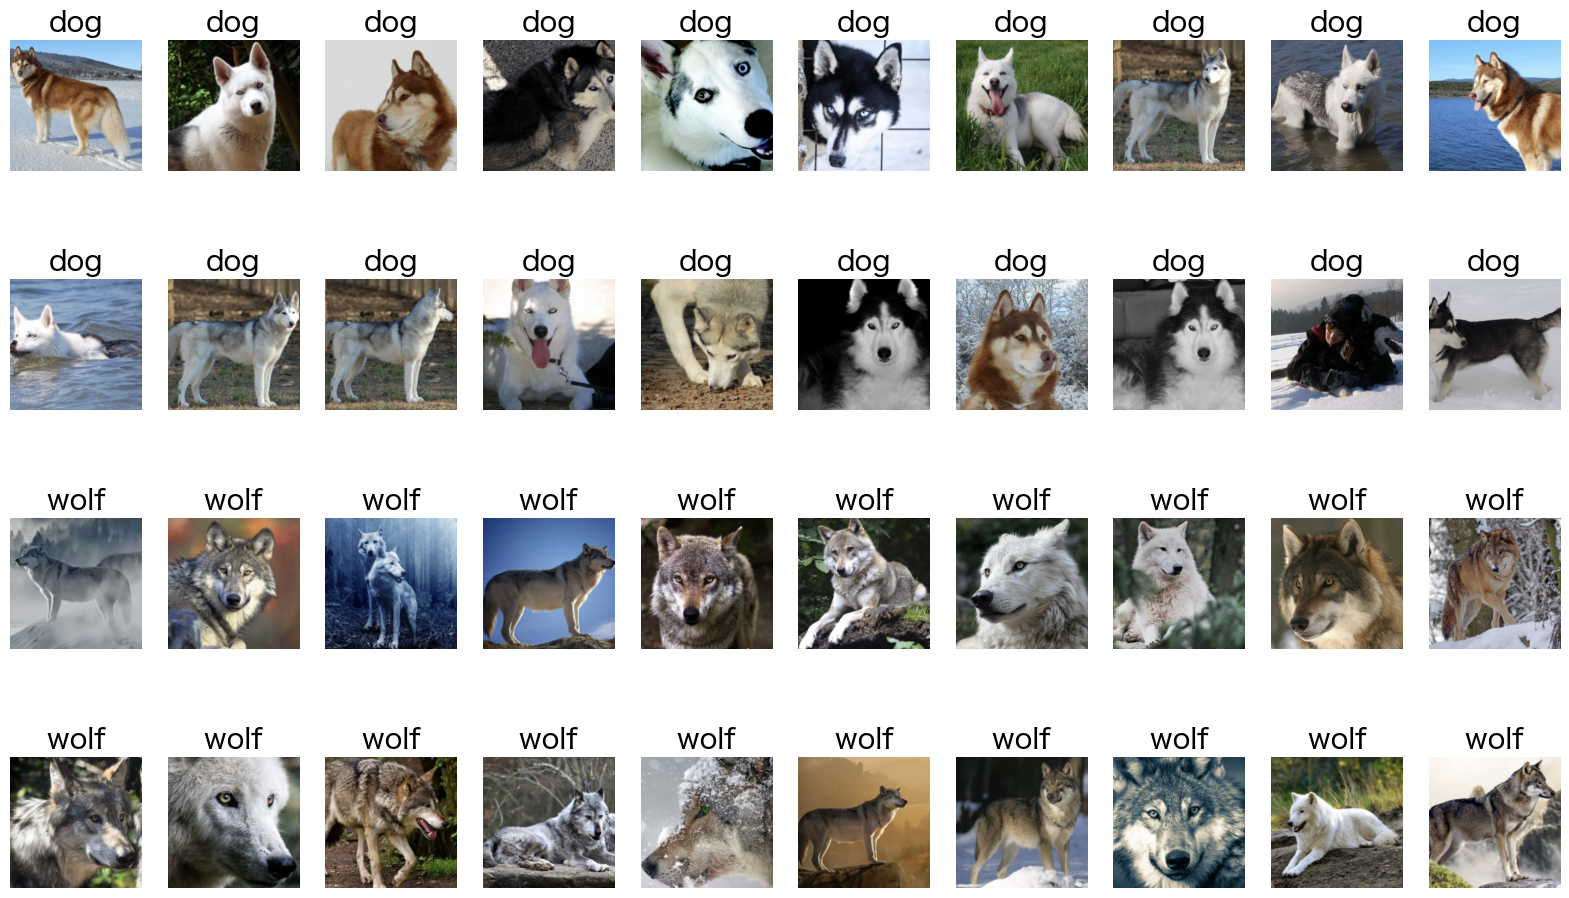

In [10]:
torch_seed()
# 訓練用データ(４0件)
show_images_labels(train_loader2, classes, None, None)

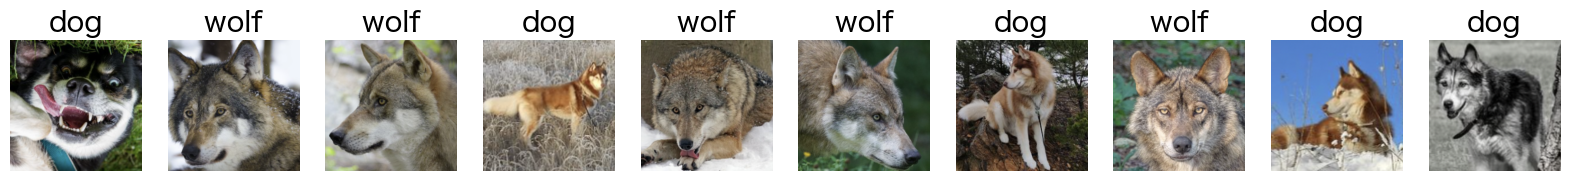

In [11]:
# 検証用データ(10件)
show_images_labels(test_loader2, classes, None, None)

## モデル定義

In [11]:
# 学習済みモデルの読み込み
# vgg19_bnをパラメータ付きで読み込む
from torchvision import models
net = models.vgg19_bn(weights='DEFAULT')

for param in net.parameters():
    param.requires_grad = False

# 乱数初期化
torch_seed()

# 最終ノードの出力を2に変更する
in_features = net.classifier[6].in_features
net.classifier[6] = nn.Linear(in_features, 2)

# AdaptiveAvgPool2d関数の取り外し
net.avgpool = nn.Identity()

# GPUの利用
net = net.to(device)

lr = 0.001
# 損失関数定義
criterion = nn.CrossEntropyLoss()

# 最適化関数定義
# パラメータ修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

## 学習の実行

In [12]:
num_epochs = 20
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch [1/20], loss: 0.65018 acc: 0.62500 val_loss: 0.37221, val_acc: 1.00000


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [2/20], loss: 0.29920 acc: 0.92500 val_loss: 0.31307, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch [3/20], loss: 0.23384 acc: 0.92500 val_loss: 0.23674, val_acc: 1.00000


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Epoch [4/20], loss: 0.08218 acc: 1.00000 val_loss: 0.26575, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Epoch [5/20], loss: 0.10470 acc: 1.00000 val_loss: 0.20026, val_acc: 1.00000


100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


Epoch [6/20], loss: 0.17965 acc: 0.95000 val_loss: 0.21260, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Epoch [7/20], loss: 0.06619 acc: 1.00000 val_loss: 0.23334, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [8/20], loss: 0.09474 acc: 0.97500 val_loss: 0.26415, val_acc: 0.80000


100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


Epoch [9/20], loss: 0.08851 acc: 0.97500 val_loss: 0.24469, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


Epoch [10/20], loss: 0.05121 acc: 0.97500 val_loss: 0.18970, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [11/20], loss: 0.16022 acc: 0.90000 val_loss: 0.21841, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [12/20], loss: 0.18741 acc: 0.95000 val_loss: 0.11880, val_acc: 1.00000


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [13/20], loss: 0.15447 acc: 0.95000 val_loss: 0.19410, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.53it/s]


Epoch [14/20], loss: 0.11760 acc: 0.95000 val_loss: 0.19902, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Epoch [15/20], loss: 0.14314 acc: 0.97500 val_loss: 0.13792, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [16/20], loss: 0.15038 acc: 0.90000 val_loss: 0.10169, val_acc: 1.00000


100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch [17/20], loss: 0.18391 acc: 0.95000 val_loss: 0.21730, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


Epoch [18/20], loss: 0.08896 acc: 0.95000 val_loss: 0.14843, val_acc: 1.00000


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [19/20], loss: 0.11007 acc: 0.95000 val_loss: 0.15721, val_acc: 0.90000


100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


Epoch [20/20], loss: 0.05969 acc: 1.00000 val_loss: 0.16792, val_acc: 0.90000


## 結果サマリー

初期状態: 損失: 0.37221 精度: 1.00000
最終状態: 損失: 0.16792 精度: 0.90000


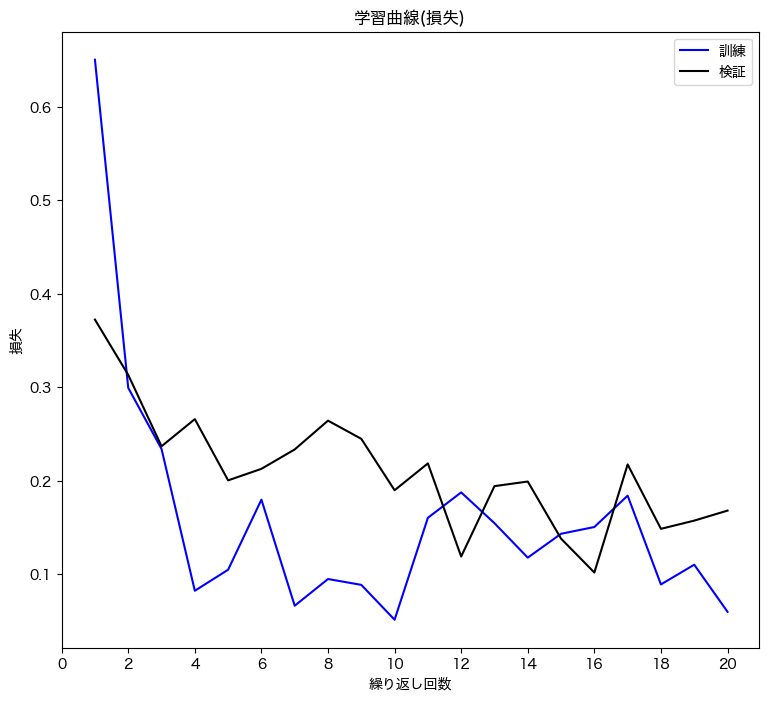

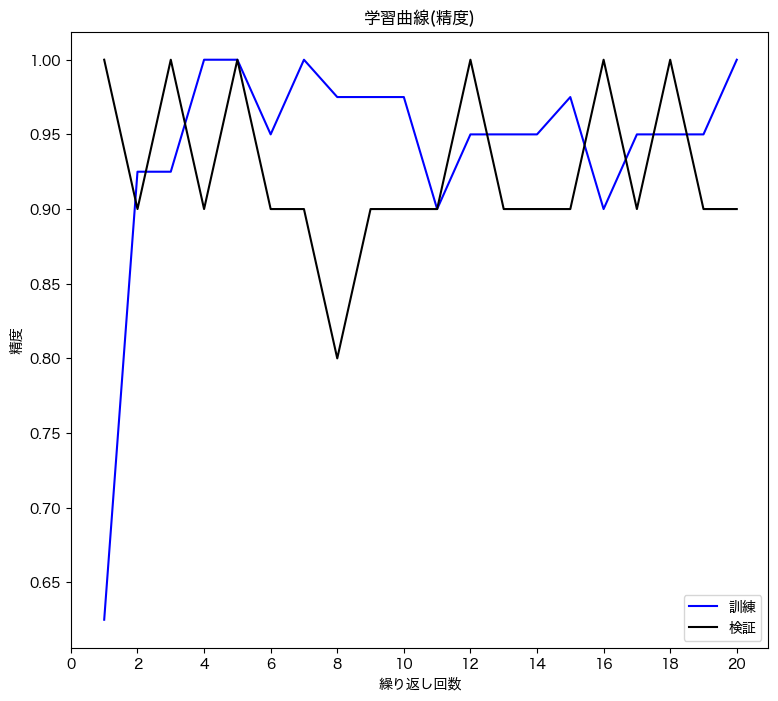

In [13]:
evaluate_history(history)

## 予測結果表示

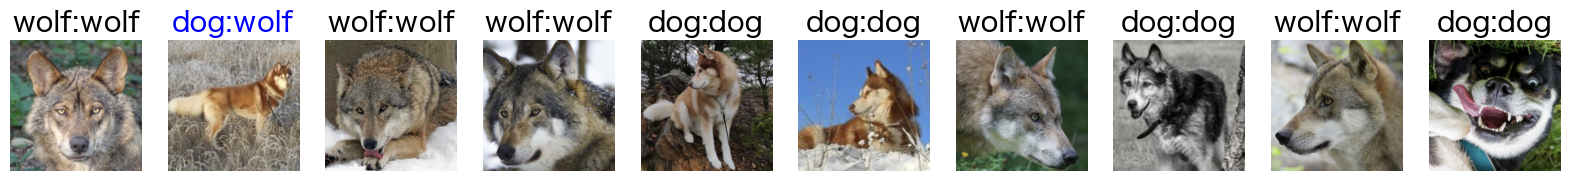

In [14]:
torch_seed()
show_images_labels(test_loader2, classes, net, device)

## モデルの保存

In [15]:
# 学習後のモデル全体をファイルに保存
torch.save(net, 'vgg19_bn_model.pth')

In [16]:
# 学習後の重みをファイルに保存
torch.save(net.state_dict(), './weight_vgg19_bn.pth')

In [27]:
from PIL import Image
image = Image.open('./data/test/dog/dog-24.png').convert('RGB')

In [28]:
# 画像を前処理
image = test_transform(image).to(device)
image.shape

torch.Size([3, 224, 224])

In [29]:
# バッチ次元を追加（torch.nnはミニバッチを想定しているため）
image = image.unsqueeze(0)
image.shape

torch.Size([1, 3, 224, 224])

In [30]:
# モデルを評価モードに設定
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [31]:
# 予測を実行（ここではGPUを使用していないため、.to(device)は不要）
with torch.no_grad():  # 勾配計算を無効化
    output = net(image)

In [32]:
# 出力から予測結果を得る（例：最もスコアが高いクラス）
_, predicted = torch.max(output, 1)

print("Predicted class:", predicted.item())

Predicted class: 0
